# Replication of Carneiro, Heckman, & Vytlacil's (2011) *Local Instrumental Variables* approach

In this notebook, I reproduce the semiparametric results from

> Carneiro, P., Heckman, J. J., & Vytlacil, E. J. (2011). [Estimating marginal returns to education.](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754) *American Economic Review, 101*(6), 2754-81. 

The goal of this endeavor is to add the semiparametric estimation method to the open-source package *grmpy* for the simulation and estimation of the generalized Roy model in Python. Currently, *grmpy* is limited to the estimation of a parametric normal version of the generalized Roy model. <br> For more, see the [online documentation](https://grmpy.readthedocs.io/en/develop/). 

This notebook makes use of the replication material provided by [Carneiro et al. (2011)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754).

In [1]:
import pandas as pd
import numpy as np
import warnings
import math

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from grmpy.check.check import check_presence_estimation_dataset
from grmpy.check.check import check_initialization_dict
from grmpy.check.check import check_presence_init
from grmpy.check.auxiliary import read_data
from grmpy.read.read import read

from semipar.estimation.estimate_auxiliary import estimate_treatment_propensity
from semipar.estimation.estimate_auxiliary import define_common_support
from semipar.estimation.estimate_auxiliary import double_residual_reg
from semipar.estimation.estimate_auxiliary import construct_Xp
from semipar.estimation.estimate_auxiliary import trim_data

from semipar.estimation.estimate import semipar_fit
from semipar.KernReg.locpoly import locpoly
from sklearn.utils import resample
from scipy.stats import norm

In [2]:
warnings.filterwarnings('ignore')

Since the replication material does not contain geographic identifiers, we are unable to merge the separate data files in such a way to accurately recreate the original data set. Therefore, we need to create a mock data set where indivudal specific data and local characteristics are merged arbitrarily (note, however, that the basic and local data are merged the same way each time, so we always work with the same mock data set).

In [3]:
# Data preparation
def process_mock_df(df, output_file):
    """This function adds squared and interaction terms to the Carneiro data set."""

    # Delete redundant columns\n",
    for key_ in ["newid", "caseid"]:
        del df[key_]

    # Add squared terms
    for key_ in ["mhgc", "cafqt", "avurate", "lurate_17", "numsibs", "lavlocwage17"]:
        str_ = key_ + "sq"
        df[str_] = df[key_] ** 2

    # Add interaction terms
    for j in ["pub4", "lwage5_17", "lurate_17", "tuit4c"]:
        for i in ["cafqt", "mhgc", "numsibs"]:
            df[j + i] = df[j] * df[i]
    
    # save output_file
    df.to_pickle(output_file + ".pkl")

In [4]:
basic = pd.read_stata('semipar/data/basicvariables.dta')
local = pd.read_stata('semipar/data/localvariables.dta')
df = pd.concat([basic, local], axis = 1)
process_mock_df(df,'semipar/data/aer-replication-mock')

In [5]:
# Replicate the results from Carneiro et al. (2011) using the mock data set created above.
quantiles, mte_u, mte_x, mte = semipar_fit("semipar/files/replication.bootstrap.yml")
mte_4 = mte / 4

Note that the MTEs are divided by 4 to get an estimate of the benefits of one 
additional year of college education rather than the benefits of obtaining a 4-year college degree.

Following Carneiro et al. (2011), I compute 90 percent confidence intervals using bootstrapped standard errors (250 iterations). 

In [6]:
def bootstrap_se(init_file, nbootstraps):
    """
    This function generates bootsrapped standard errors
    given an init_file and the number of bootsraps to be drawn.
    """
    check_presence_init(init_file)

    dict_ = read(init_file)
    # np.random.seed(dict_["SIMULATION"]["seed"]) # needed?

    check_presence_estimation_dataset(dict_)
    check_initialization_dict(dict_)

    nbins = dict_["ESTIMATION"]["nbins"]
    trim = dict_["ESTIMATION"]["trim_support"]
    rbandwidth = dict_["ESTIMATION"]["rbandwidth"]
    bandwidth = dict_["ESTIMATION"]["bandwidth"]
    gridsize = dict_["ESTIMATION"]["gridsize"]
    a = dict_["ESTIMATION"]["ps_range"][0]
    b = dict_["ESTIMATION"]["ps_range"][1]

    logit = dict_["ESTIMATION"]["logit"]
    show_output = dict_["ESTIMATION"]["show_output"]
    
    # Distribute initialization information.
    data = read_data(dict_["ESTIMATION"]["file"])
    
    # Prepare empty arrays to store output values
    mte_4_boot = np.zeros([gridsize, nbootstraps])
    # quantiles = np.zeros([gridsize, nbootstraps])
    
    for i in range(nbootstraps): 
        boot = resample(data, replace=True, n_samples=len(data), random_state=None)
        
         # Process data for the semiparametric estimation.
        indicator = dict_["ESTIMATION"]["indicator"]
        D = boot[indicator].values
        Z = boot[dict_["CHOICE"]["order"]]

        # The Local Instrumental Variables (LIV) approach

        # 1. Estimate propensity score P(z)
        ps = estimate_treatment_propensity(D, Z, logit, show_output)

        # 2a. Find common support
        treated, untreated, common_support = define_common_support(
            ps, indicator, boot, nbins, show_output
        )

        # 2b. Trim the data
        if trim is True:
            boot, ps = trim_data(ps, common_support, boot, show_output)

        # 3. Double Residual Regression
        # Sort data by ps
        boot = boot.sort_values(by="ps", ascending=True)
        ps = np.sort(ps)

        X = boot[dict_["TREATED"]["order"]]
        Xp = construct_Xp(X, ps)
        Y = boot[["wage"]]

        b0, b1_b0 = double_residual_reg(ps, X, Xp, Y, rbandwidth, show_output)

        # Turn the X, Xp, and Y DataFrames into np.ndarrays
        X_arr = np.array(X)
        Xp_arr = np.array(Xp)
        Y_arr = np.array(Y).ravel()

        # 4. Compute the unobserved part of Y
        Y_tilde = Y_arr - np.dot(X_arr, b0) - np.dot(Xp_arr, b1_b0)

        # 5. Estimate mte_u, the unobserved component of the MTE,
        # through a locally quadratic regression
        quantiles, mte_u = locpoly(ps, Y_tilde, 1, 2, bandwidth, gridsize, a, b)

        # 6. construct MTE
        # Calculate the MTE component that depends on X
        mte_x = np.dot(X, b1_b0).mean(axis=0)

        # Put the MTE together
        mte = mte_x + mte_u
        mte_4_boot[:,i] += mte / 4
        
    return mte_4_boot

First, draw $B = 250$ independent bootstrap samples and compute the *MTE* $ \ \hat{\theta}^{MTE}(b)$ for each bootstrap replication $b = 1,..,B$. 

In [7]:
# Draw bootstraps and calculate MTE estimates.
nbootstraps = 250
mte_4_boot = bootstrap_se('semipar/files/replication.bootstrap.yml', nbootstraps)

Second, estimate the standard error of $\hat{\theta}^{MTE}$, denoted by $\widehat{\mathbf{se}}_B$, separately for each gridpoint $u_D$:

$$ \widehat{\mathbf{se}}_B = \frac{1}{B-1} \sum_{b = 1}^{B}{\{ \hat{\theta}}^{MTE}(b) \ - \ \hat{\theta}^{MTE}(\cdot)    \}^2 $$

where $\hat{\theta}^{MTE}(\cdot)$ is the replicated *MTE* of the baseline data set.

In [8]:
_ = np.zeros([len(mte_4_boot), nbootstraps])

In [9]:
for row in range(len(mte_4_boot)):
    for column in range(nbootstraps):
        _[row,column] = ((mte_4_boot[row,column] - mte_4[row])**2)

se_boot = (1 / (nbootstraps - 1)) * np.sum(_, axis=1)

In [10]:
# Compute 90 percent confidence intervals
con_u = mte_4 + norm.ppf(0.95) * se_boot
con_d = mte_4 - norm.ppf(0.95) * se_boot

In [11]:
# import original results
mte_ = pd.read_csv('semipar/data/mte_semipar_original.csv')

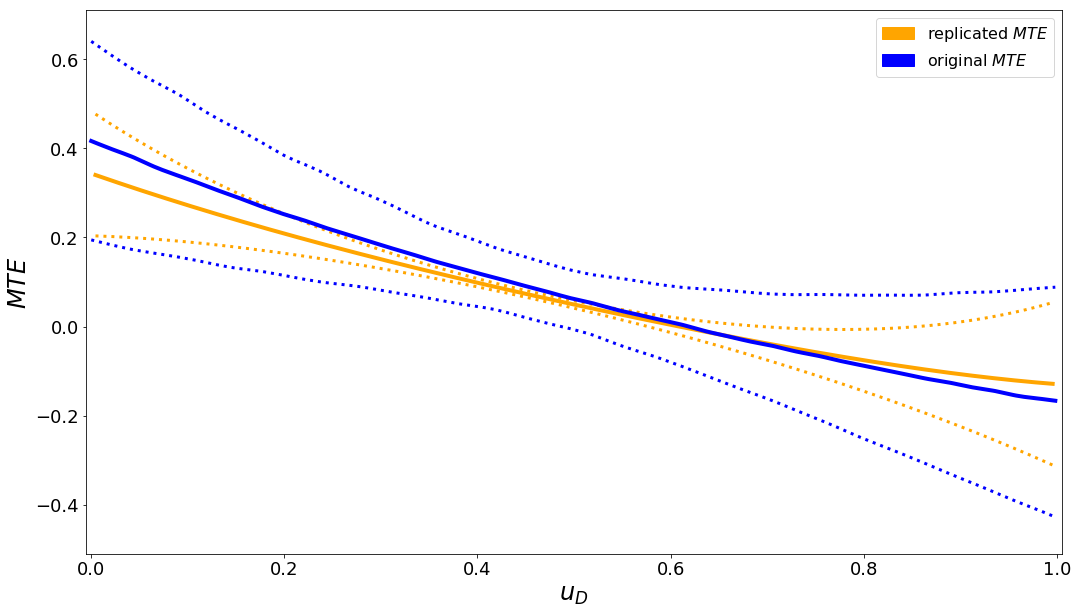

In [12]:
# Plot
ax = plt.figure(figsize=(17.5, 10)).add_subplot(111)

ax.set_ylabel(r"$MTE$", fontsize=24)
ax.set_xlabel("$u_D$", fontsize=24)
ax.tick_params(axis="both", which="major", labelsize=18)

# Plot replicated curves
ax.plot(quantiles, mte_4, label="replicated $MTE$", color="orange", linewidth=4)
ax.plot(quantiles, con_u, color="orange", linestyle=":", linewidth=3)
ax.plot(quantiles, con_d, color="orange", linestyle=":", linewidth=3)


# Plot original curve
ax.plot(mte_['quantiles'], mte_['mte'], label="$original MTE$", color="blue", linewidth=4)
ax.plot(mte_['quantiles'], mte_['con_u'], color="blue", linestyle=":", linewidth=3)
ax.plot(mte_['quantiles'], mte_['con_d'], color="blue", linestyle=":", linewidth=3)

ax.set_ylim([-0.51, 0.71])
ax.set_xlim([-0.005, 1.005])

blue_patch = mpatches.Patch(color="orange", label="replicated $MTE$")
orange_patch = mpatches.Patch(color="blue", label="original $MTE$")
plt.legend(handles=[blue_patch, orange_patch], prop={"size": 16})
plt.show()


People with the highest returns to education (those who have low unobserved resistance $u_D$) are more likely to go to college. Note that the returns vary considerably with $u_D$. Low $u_D$ students have returns of up to 40% per year of college, whereas high $u_D$ people, who would loose from attending college, have returns of approximately - 15%.

As the graph shows, the curves of the replicated MTEs definitely go in the direction of the original MTE but are flatter on the margins. Compared to the original plot, the 90 percent confidence bands are too tight, particularly in the mid section of $u_D$. 
The deviations might be due to the use of a mock data set combined with the utilization of nonparametric techniques which makes the semiparametric replication more sensitive compared to a parametric specification.